enter parameterised angle (theta) for qubit-0: 0 
enter parameterised angle (phi) for qubit-1: 0


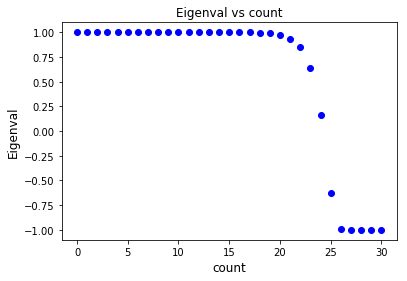

final Eigenval::
theta: 1.57079632679490, phi: 3.14159265358979, result: -1.00000000000000
OPENQASM 2.0;
include "qelib1.inc";
qreg q1[2];
creg c1[2];
rx(1.57079632679490) q1[0];
rx(3.14159265358979) q1[1];
cx q1[0],q1[1];
z q1[0];
z q1[1];
cx q1[0],q1[1];
cx q1[1],q1[0];
cx q1[0],q1[1];



In [2]:
"""To find minimum Eigenvalue of a given Hamiltonian (from hamiltonian_cir)"""

import sympy as sym
from math import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.visualization import plot_bloch_vector, plot_histogram
from matplotlib import pyplot
from qiskit import execute

backend = 'local_qasm_simulator'
q_r = QuantumRegister(2)
c_r = ClassicalRegister(2)

q_c = QuantumCircuit(q_r, c_r)

"""param_cir is my test parameterised variational circuit
   Since the given Hamiltonian is 4X4 matrix, 2 parameterised qubits (theta and phi) are taken
   Their mutual interaction is simulated with CNOT gate"""
def param_cir(circuit, qbit0, theta, qbit1, phi):
    circuit.rx(theta, qbit0)
    circuit.rx(phi, qbit1)
    circuit.cx(qbit0, qbit1)
    hamiltonian_cir(circuit, qbit0, qbit1)

def hamiltonian_cir(circuit, qbit0, qbit1):
    circuit.z(qbit0)
    circuit.z(qbit1)
    circuit.cx(qbit0, qbit1)
    circuit.cx(qbit1, qbit0)
    circuit.cx(qbit0, qbit1)
    
theta, phi = sym.symbols('theta phi')

theta_mat = sym.Matrix([theta])
phi_mat = sym.Matrix([phi])

"""Input parameterised tensor state"""
in_state_tensor = sym.Matrix([
    [sym.cos(theta/2)*sym.cos(phi/2)],
    [sym.cos(theta/2)*sym.sin(phi/2)],
    [sym.sin(theta/2)*sym.cos(phi/2)],
    [sym.sin(theta/2)*sym.sin(phi/2)]])

cx_mat = sym.Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]])

"""symbolic output of param_cir"""
in_ansatz = cx_mat * in_state_tensor

"""calculating bra of in_ansatz"""
in_dual_ansatz = in_ansatz.T

"""Hamiltonian matrix output from hamiltonian_cir - need to find min Eigenvalue for it"""
in_hamiltonian = sym.Matrix([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, -1, 0, 0],
    [0, 0, 0, 1]])

"""calculating expected symbolic value of the Hamiltonian"""
hamiltonian_expectation = ((in_dual_ansatz * in_hamiltonian * in_ansatz) / (in_dual_ansatz * in_ansatz))

"""partial diff with respect to theta and phi respectively"""
exp_diff_theta = sym.diff(hamiltonian_expectation, theta)
exp_diff_phi = sym.diff(hamiltonian_expectation, phi)

alpha = float(input("enter parameterised angle (theta) for qubit-0: "))
beta = float(input("enter parameterised angle (phi) for qubit-1: "))
count = 0

"""take precaution"""
if alpha == 0:
    alpha = .0001
if beta == 0:
    beta = .0001
    
theta_mat_val = theta_mat.subs(theta, alpha).as_mutable()
phi_mat_val = phi_mat.subs(phi, beta).as_mutable()

output_result = hamiltonian_expectation.subs(theta, alpha).subs(phi, beta).as_mutable()
diff_wrt_alpha = exp_diff_theta.subs(theta, alpha).subs(phi, beta).as_mutable()
diff_wrt_beta = exp_diff_phi.subs(theta, alpha).subs(phi, beta).as_mutable()

pyplot.plot(count, output_result[0,0], 'ob-')

"""gradient descent algo - the experiment shows around count 10 (used 30 here) is sufficient to get min"""
while count < 30:
    theta_mat_val = theta_mat_val - diff_wrt_alpha
    phi_mat_val = phi_mat_val - diff_wrt_beta
    
    output_result = hamiltonian_expectation.subs(theta, theta_mat_val[0,0]).subs(phi, phi_mat_val[0,0]).as_mutable()
    diff_wrt_alpha = exp_diff_theta.subs(theta, theta_mat_val[0,0]).subs(phi, phi_mat_val[0,0]).as_mutable()
    diff_wrt_beta = exp_diff_phi.subs(theta, theta_mat_val[0,0]).subs(phi, phi_mat_val[0,0]).as_mutable()
    count = count + 1
    pyplot.plot(count, output_result[0,0], 'ob-')

pyplot.xlabel("count", fontsize=12)
pyplot.ylabel("Eigenval", fontsize=12)
pyplot.title('Eigenval vs count')
pyplot.show()

print("final Eigenval::")
print("theta: {}, phi: {}, result: {}".format(theta_mat_val[0,0], phi_mat_val[0,0], output_result[0,0]))

param_cir(q_c, q_r[0], theta_mat_val[0,0], q_r[1], phi_mat_val[0,0])
QASM_source = q_c.qasm()
print(QASM_source)

In [ ]:
.01
